# Snapshot Data Reduction Scripts

The two functions provided reduce snapshot info a readable format for the SKIRT radiative transfer code and make simple projections of snapshot data for by eye visualizations.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import importlib.util

from crc_scripts.utils.stellar_hsml_utils import get_particle_hsml
from crc_scripts.figure import Figure,Projection
from crc_scripts.io.gizmo import load_halo
import crc_scripts.utils.data_calc_utils as calc
from crc_scripts import config

def create_SKIRT_particle_files(snap_dir, snap_num, output_dir, import_dust=True, file_prefix=None, use_halo_file=False):
    '''
    This function extracts and reduces the star and gas particle data from the specified simulation snapshot 
    into SKIRT input file. When extracting dust data it only uses the dust-to-metals (D/Z) ratio.

    Parameters
    ----------
    snap_dir : string
        Name of snapshot directory
    snap_num : int
        Snapshot number
    output_dir : string
        Name of directory where SKIRT outputs will be written to
    import_dust : boolean
        Sets whether dust information will be extracted from simulation.
    file_prefix : string, optional
        Prefix for star.dat and gas.dat files.
    use_halo_file : string, optional
        Use halo files (i.e. AHF) to initially center halo. Only really needed for high-z or subhalos.
    '''
    # This loads the galactic halo from the snapshot
    mode='AHF' if use_halo_file else None
    halo = load_halo(snap_dir, snap_num, mode=mode)
    # This orientates the halo so that the galactic disk is face-on
    print("Orientating halo")
    halo.set_orientation()

    if not halo.sp.Flag_DustSpecies and import_dust:
        print("WARNING: import_dust set to True but this snapshot does not have dust. Set import_dust to False.")

    # Load data for star particles (ptype = 4)
    p4 = halo.loadpart(4)
    # x,y,x coordinates
    coords = p4.get_property('position')
    x, y, z = coords[:,0], coords[:,1], coords[:,2]
    # Compute the star softening lengths. This takes some time.
    print("Calculating star particle smoothing lengths...")
    h = get_particle_hsml(x, y, z)

    spam_spec = importlib.util.find_spec("gizmo_analysis")
    has_gizmo_analysis = spam_spec is not None

    if has_gizmo_analysis:
        # mass at formation, metallicity, and age
        m, Z, t = p4.get_property('M_form'), p4.get_property('Z_all')[:,0], 1e9*p4.get_property('age')
    else:
        print("WARNING: gizmo_analysis not installed. This module is needed to determine the zero-age stellar mass which SKIRT expects for star particles.")
        print("This will instead use the current star mass, which can underestimate the mass by <=30%.")
        print("You can pip install gizmo_analysis @ https://git@bitbucket.org/awetzel/gizmo_analysis.git")
        # current mass , metallicity, and age
        m, Z, t = p4.get_property('M'), p4.get_property('Z_all')[:,0], 1e9*p4.get_property('age')
    
    f = open(output_dir+"/"+file_prefix+"star.dat", 'w')
    # Write header for star file
    header =    '# star.dat \n' + \
                '# Column 1: position x (pc)\n' + \
                '# Column 2: position y (pc)\n' + \
                '# Column 3: position z (pc)\n' + \
                '# Column 4: smoothing length (pc)\n' + \
                '# Column 5: mass (Msun)\n' + \
                '# Column 6: metallicity (1)\n' + \
                '# Column 7: age (yr)\n'
    f.write(header)
    # Step through each star particle and write its data
    for i in range(p4.npart):
        line = "%.2f %.2f %.2f %.2f %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],1e3*h[i],m[i],Z[i],t[i])
        f.write(line)
    f.close()

    print("Star data written to star.dat...")

    # Load gas particle data (ptype = 0)
    p0 = halo.loadpart(0)
    # x,y,x coordinates
    coords = p0.get_property('position')
    x, y, z = coords[:,0], coords[:,1], coords[:,2]
    # If the snapshots include dust amounts, give those to SKIRT and set D/Z to 1
    # Else just assume a constant D/Z everywhere.
    if import_dust:
        # smoothing length, dust mass, and temperature
        h, m, T = p0.get_property('size'), p0.get_property('M_dust'), p0.get_property('temperature')
    else:
        # smoothing length, gas mass, metallicity, and temperature
        h, m, Z, T = p0.get_property('size'), p0.get_property('M'), p0.get_property('Z_all')[:,0], p0.get_property('temperature')

    f = open(output_dir+"/"+file_prefix+"gas.dat", 'w')
    # Make header for gas/dust. Needs to be in this specific order
    header =   '# gas.dat \n' + \
               '# Column 1: position x (pc)\n' + \
               '# Column 2: position y (pc)\n' + \
               '# Column 3: position z (pc)\n' + \
               '# Column 4: smoothing length (pc)\n'
    if import_dust:
        header += '# Column 5: dust mass (Msun)\n' + \
                  '# Column 6: temperature (K)\n'
    else:
        header += '# Column 5: mass (Msun)\n' + \
                  '# Column 6: metallicity (1)\n' + \
                  '# Column 7: temperature (K)\n'
    f.write(header)

    if import_dust:
        for i in range(p0.npart):
            line = "%.2f %.2f %.2f %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],1e3*h[i],m[i],T[i])
            f.write(line)
    else:
        for i in range(p0.npart):
            line = "%.2f %.2f %.2f %.3e %.3e %.3e %.3e\n" %(1e3*x[i],1e3*y[i],1e3*z[i],1e3*h[i],m[i],Z[i],T[i])
            f.write(line)
    f.close()

    print("Gas/Dust data written to gas.dat...")

def create_galaxy_projection(snap_dir, snap_num, foutname='snap_projection.png', use_halo_file=False, pixel_res=0.05, proj_L=15, properties=['sigma_gas'], prop_limits=[], prop_cmaps=[],
                            log_cmaps=[] ,labels=[], sub_proj=False, sub_L=8):
    '''
    This function takes the specified snapshot and makes a projection of the specified properties. The property can either be a surface density (i.e sigma_gas)
    or the median a physical property (i.e. temperature). The default projection is face-on with the galaxy (x-y axis), but you can add a subb-projection 
    along another direction (x-z,y-z).

    Parameters
    ----------
    snap_dir : string
        Name of snapshot directory
    snap_num : int
        Snapshot number
    foutname: string
        Name of file for saved image.
    use_halo_file : string, optional
        Use halo files (i.e. AHF) to initially center halo. Only really needed for high-z or subhalos.
    pixel_res : double
        Size of each projection pixel in kpc. If this is too small you will start to bin individual particles.
    properties : list
        List of properties you want individual projections for. Check the crc_scripts.config.PROP_INFO dictionary for supported properties.
    prop_limits : list
        List of lower and upper limits for each property.
    prop_cmaps : list
        List of colormaps for each property.
    log_cmaps : list
        List setting if colormap should be in log space for each property.
    label : list
        List of labels which will appear in the corner for each projection.
    proj_L : double
        Sets the size of each projection in kpc (for reference the Milky Way has a disk size of ~10 kpc).
    sub_proj : bool
        Sets whether you want another subprojection underneath the main projection with a projection angle that is  offset by 90 degrees.
    sub_L : double
        Sets the size of each subprojection in kpc (~5 kpc is good for a disk galaxy).
    
    '''

    mode='AHF' if use_halo_file else None
    halo = load_halo(snap_dir, snap_num, mode=mode)
    # Orientate the galaxy so it is face-on
    halo.set_orientation()
    # Initialize projection figure
    L = proj_L
    height_ratios = [L/sub_L,1]
    new_proj = Projection(len(properties), add_sub_proj=sub_proj, add_colorbars=True, height_ratios=height_ratios)
    # Create projections for each property and plot the projection
    for j,prop in enumerate(properties):
        new_proj.set_proj_axis(j, prop, L, axes_visible=False)
        # Create x-y projection using a 2D histogram
        main_pixel_stats, main_xedges, main_yedges, main_extent = calc.calc_projected_prop(prop, halo, [L,L,L], pixel_res=pixel_res, proj='xy')
        if sub_proj:
            # Create x-z subprojection using a 2D histogram
            sub_pixel_stats, sub_xedges, sub_yedges, sub_extent = calc.calc_projected_prop(prop, halo, [L,sub_L,L], pixel_res=pixel_res, proj='xz')
        else:
            sub_pixel_stats=None; sub_extent=None
        # x-z projection
        # Create the projection
        if labels is not None:
            label = labels[j]
        else:
            label=None
        new_proj.plot_projection(j, main_pixel_stats, main_extent, sub_proj_data=sub_pixel_stats, sub_extent=sub_extent,
                                 cmap= prop_cmaps[j], v_limits = prop_limits[j],v_log=log_cmaps[j], label=label)

    new_proj.save(foutname)

## Reduce snapshot data

In [2]:
# Path to simulation snapshots
snap_dir = '/N/project/choban_group/present_day_suite/m12i_res7100/output'
# Number of snapshot you want to open
snap_num = 600
# Path you want to save reduced data to
output_dir = './'
# Do you have a halo finder file (i.e. AHF) to center the galaxy on?
use_halo_file=False
# Set whether you want to import the dust mass from the simulation directly (only use this if the simulation has live dust) or 
# only import the gas mass and metallicity to be used with an assumed dust amount
import_dust = False

file_prefix = 'm12i_'

create_SKIRT_particle_files(snap_dir, snap_num, output_dir, import_dust=import_dust,file_prefix=file_prefix,use_halo_file=use_halo_file)

/N/project/choban_group/present_day_suite/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
No halo file given so galaxy centered on median position of gas particles with nH>10 cm^-3. This may not always work.
Orientating halo
assigning center of galaxy:
  center position [kpc] = 41821.601, 44186.981, 46265.911
  center velocity [km/s] = -51.9, 75.5, 94.7
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.127, min/med = 0.132, med/maj = 0.963
Calculating star particle smoothing lengths...
True
Star data written to star.dat...
Gas/Dust data written to gas.dat...


## Create projection visualization

/N/project/choban_group/present_day_suite/m12i_res7100/output/snapdir_600/snapshot_600.0.hdf5
No halo file given so galaxy centered on median position of gas particles with nH>10 cm^-3. This may not always work.
assigning center of galaxy:
  center position [kpc] = 41821.601, 44186.981, 46265.911
  center velocity [km/s] = -51.9, 75.5, 94.7
assigning principal axes:
  using ptype 4 particles at radius < 10 kpc
  using ptype 4 particles with age = [0, 1] Gyr
  axis ratios:  min/maj = 0.127, min/med = 0.132, med/maj = 0.963


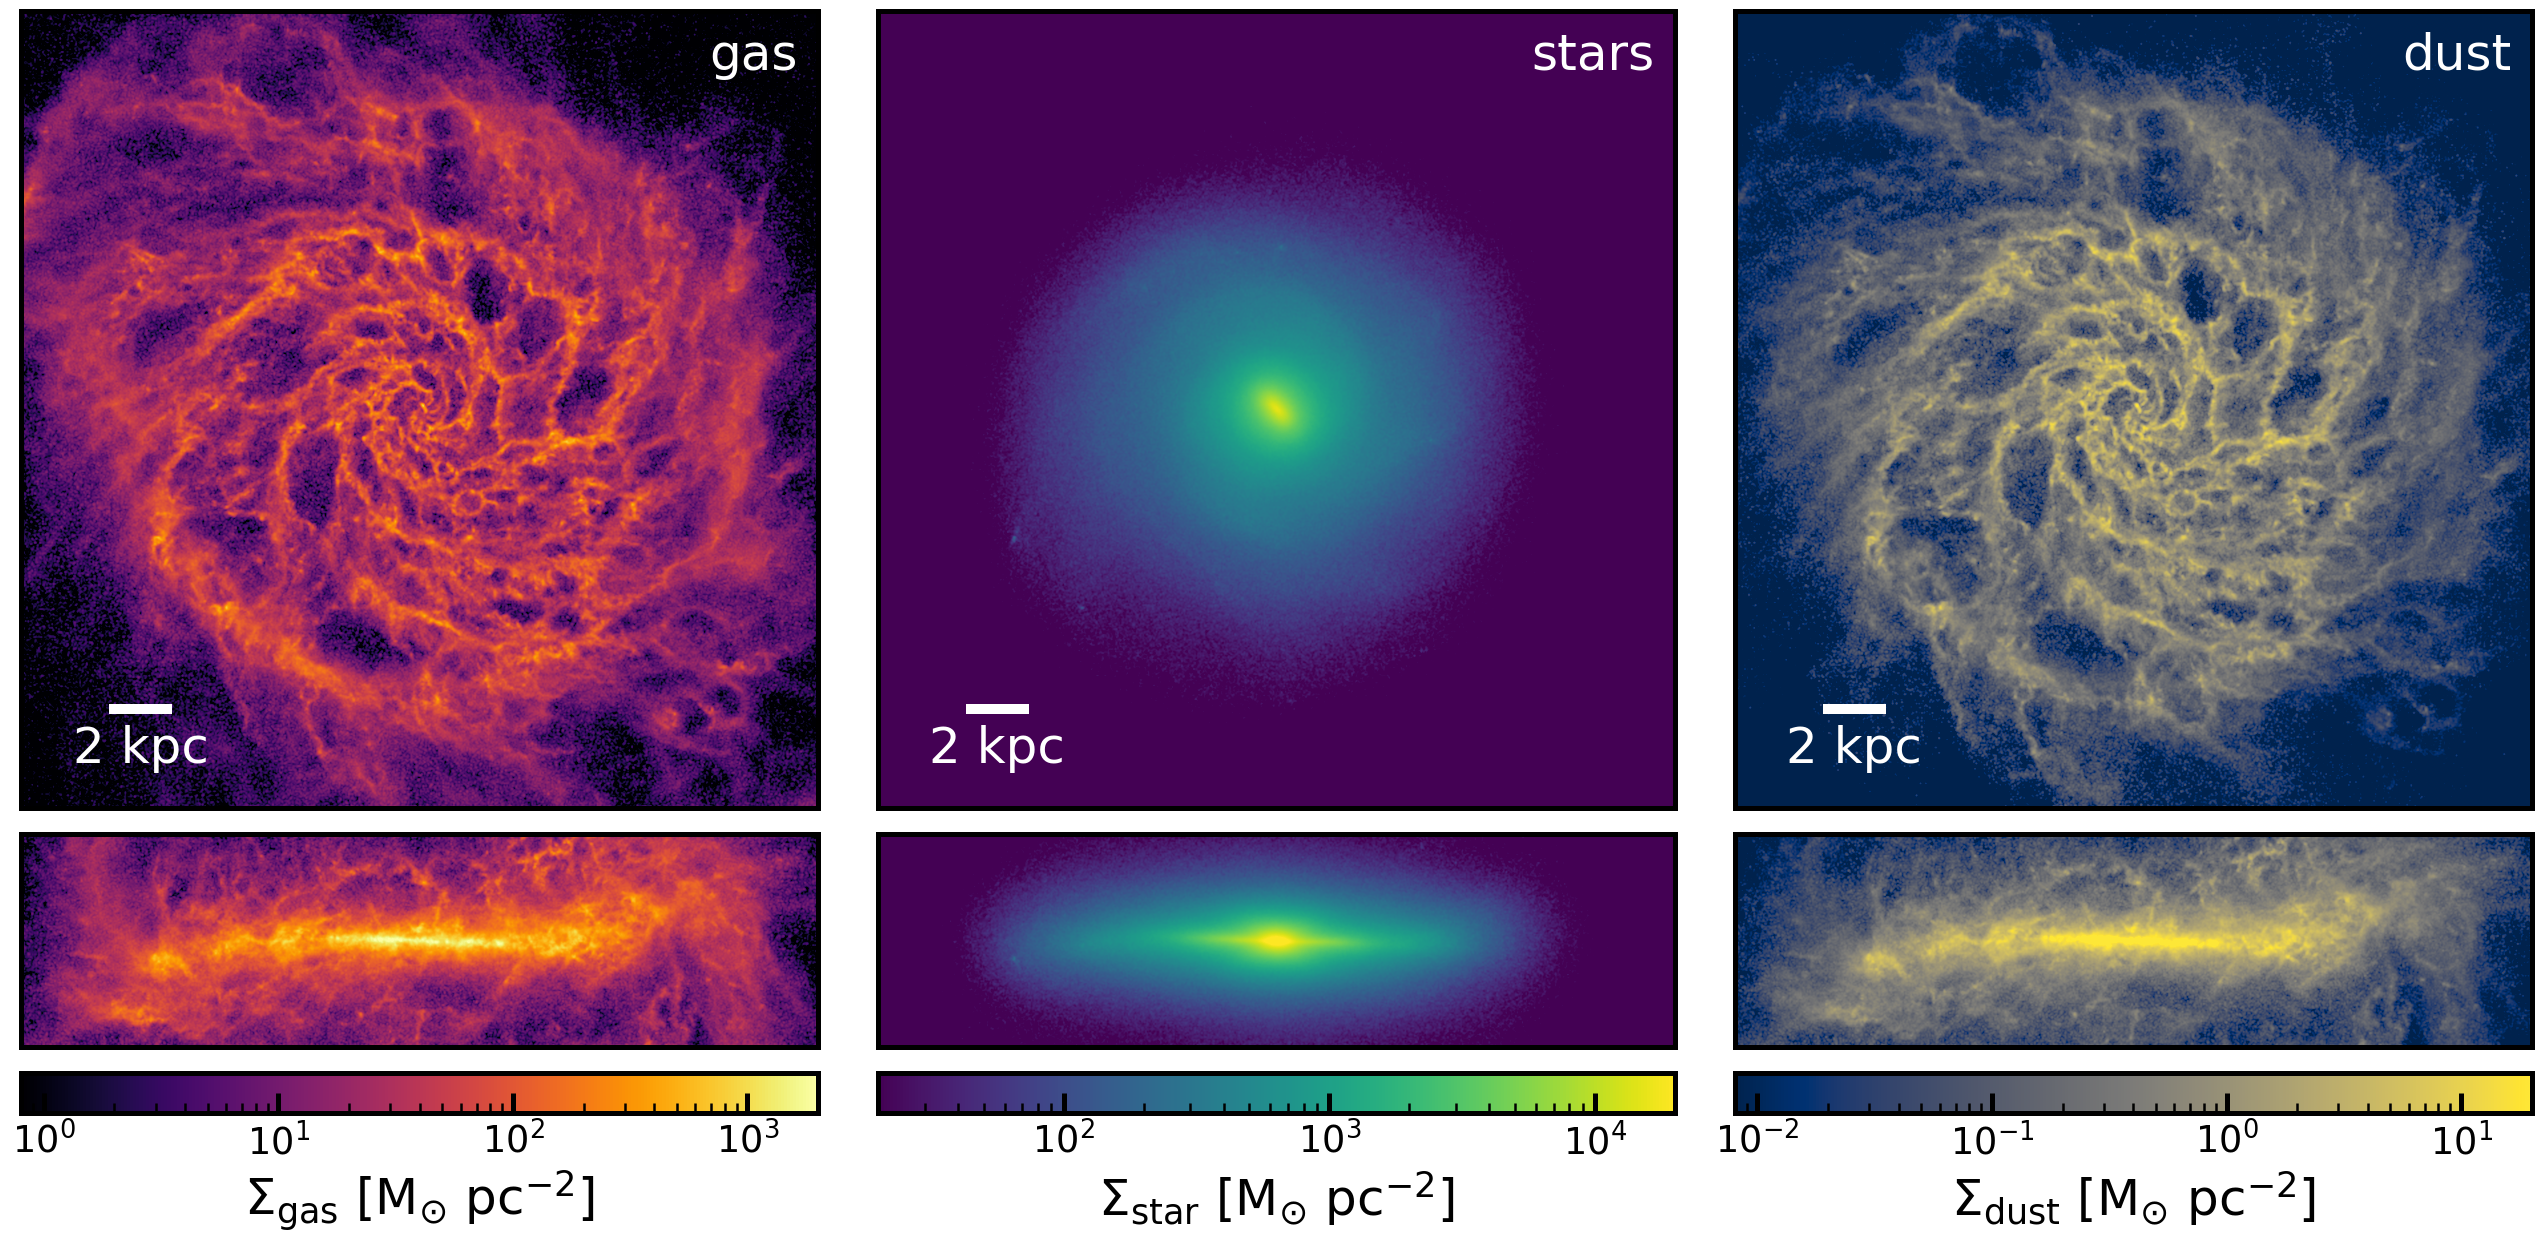

In [3]:
# Physical size of projection 
proj_L = 15 # kpc
# Size resolution (kpc) for each "pixel" in projection
pixel_res=0.05
# Properties to plot projections of. Can be surface densities (total mass in pixel divied by pixel size) or properties like T (median value of all particles in pixel)
properties = ['sigma_gas','sigma_star','sigma_dust']
# Limits for projection of each property. Defaults if not set
prop_limits = [[8E-1,2E3],[2E1,2E4],[8E-3,2E1]]
# Colormaps for each projection
prop_cmaps = ['inferno','viridis','cividis']
# Do you want log colormaps for each property (default = True)
log_cmaps = [True]*len(properties)
# Labels for each projection is so desired
labels = ['gas','stars','dust']
# Physical size of projection 
proj_L = 30 # kpc
# Do you want a secondary projection from an orthogonal axis (i.e. edge-on)
sub_proj = True
# size of secondary projection
sub_L = 8 # kpc

create_galaxy_projection(snap_dir, snap_num, use_halo_file=use_halo_file, proj_L=proj_L, pixel_res=pixel_res, 
                            properties=properties, prop_limits=prop_limits, prop_cmaps=prop_cmaps,
                            log_cmaps=log_cmaps ,labels=labels, sub_proj=sub_proj, sub_L=sub_L)